# OF example

Load MIDAS data with threshold triggers. Make PSD and pulse templates, then run OF

Changelog

Oct 24 2024: First version

In [1]:
import sys
import glob
sys.path.append('..')
from arqpy import *

In [2]:
# data + channels to use
datadir = '/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/'
filename_pattern = datadir + 'RUN08410_DUMP000*.mid.gz'
fns = sorted(glob.glob(filename_pattern))
chs = ['PBS2','PFS2'] # channels to use (which also serve as dictionary keys)
names = ['NFC2 A','NFC2 B']
#taus = [[1e-5,3e-4],[1e-5,3e-4]] # pulse rise/fall times (seconds)

# general
fsamp = 625000 # Hz
pretrig = 1000 # bins (usually 4096)
posttrig = 4000
tracelen = pretrig + posttrig # trace used for RQ processing
psdfreq = np.fft.rfftfreq(tracelen,1/fsamp)
ADC2A = 1/2**16 *8/5e3 /2.4/4 # 16-bit ADC, 8V range, 5kOhm R_FB, 2.4 turn ratio, gain = 4

The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409181855
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409181855
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08410_DUMP0000.mid.gz
RawDat

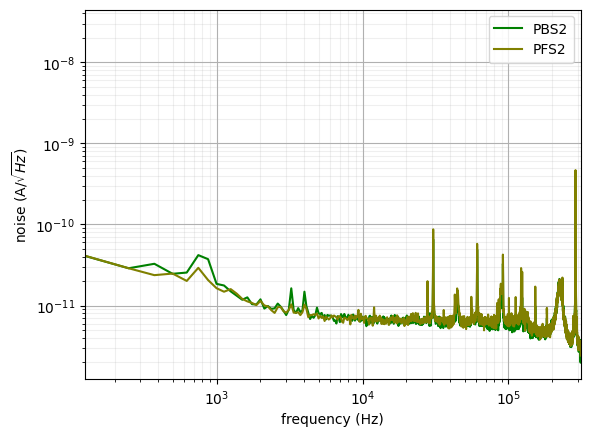

In [3]:
# make PSDs
det = 1 # MIDAS Det01
# load traces - may take a while
traces = loadEvents(files=fns[:1],detectors=[det],chs=chs,ADC2A=ADC2A)
# compute PSDs, then plot
psds = makePSDs(traces[det],chs=chs,nbins=tracelen,ntraces=100,fsamp=fsamp)
plotPSDs(psds,fsamp=fsamp,tracelen=tracelen)

The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDat

(1000.0, 5000.0)

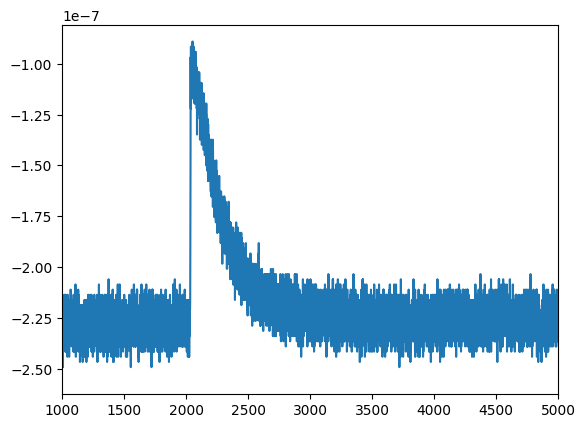

In [4]:
# find a pulse to fit somehow
filename_pattern = datadir + 'RUN08424_DUMP000*.mid.gz'
fns = sorted(glob.glob(filename_pattern))
traces = loadEvents(files=fns[:1],detectors=[det],chs=chs,ADC2A=ADC2A)

ch = chs[0]
evn = 0
trace = traces[1][chs[0]][evn]
plt.plot(trace)
plt.xlim(1000,5000)

PBS2 [ 1.34441092e-07  5.21884106e-06  4.00625765e-04  1.29197366e-04
 -2.27433585e-07]
PFS2 [ 3.05905501e-07  2.81259101e-06  4.61703602e-04  1.28944420e-04
 -2.30827871e-07]


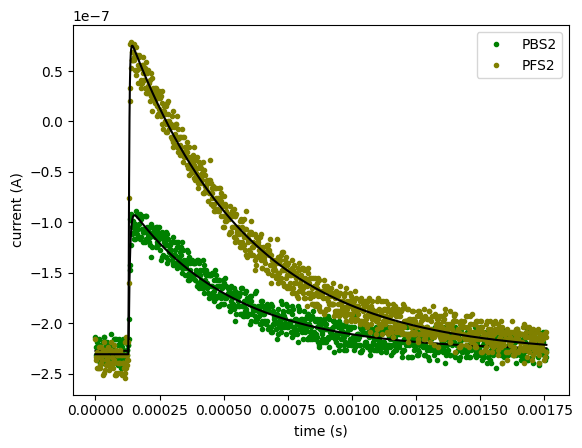

In [5]:
# make pulse templates
templates = {}
evn = 0
pulse_ind = 2052
for ch in chs:
    trace = traces[1][ch][evn][pulse_ind-100:pulse_ind+1000]
    t = np.arange(len(trace))/fsamp
    mle = fitPulse(t,trace)
    templates[ch] = pulse2(np.arange(tracelen)/fsamp,*mle[1:3],t0=pretrig/fsamp)
    print(ch,mle)
    
    # plot
    plt.plot(t,trace,'.',color=MIDAScolors[MIDASchs.index(ch)],label=ch)
    plt.plot(t,mle[0]*pulse2(t,*mle[1:-1])+mle[-1],'k-')
plt.xlabel('time (s)')
plt.ylabel('current (A)')
plt.legend()

In [6]:
# instantiate Reduced Quantity object
maxchi2freq = 1e4
rq = RQ(data=fns, chs=chs, ch_names=names, detector=1,
        fsamp=fsamp, ADC2A=ADC2A,
        pretrig=pretrig, posttrig=posttrig, 
        PSDs=psds, pulse_templates=templates,
        maxchi2freq=maxchi2freq)

In [7]:
# make OF (for RQs AND triggering) and plot
rq.makeOF()

In [8]:
# trigger options
trigger_mode = 1 # 0 - threshold, 1 - filter+threshold, 2 - random, 3 - external/LEMO
trigger_channels = chs # channels to trigger on
trigger_threshold = [1e-7,2e-7] # A
threshold = {}
deactivation_threshold = {}
for i,ch in enumerate(chs):
    threshold[ch] = trigger_threshold[i]
    deactivation_threshold[ch] = 0.5*threshold[ch]
randomrate = 0 # random triggers to add per trace

rq.runTrigger(mode=trigger_mode, chs=trigger_channels, randomrate=randomrate,
              threshold=threshold, deactivation_threshold=deactivation_threshold,remove_filter_offset=True)
# for fn in fns:
#    load all evs
#    traces = []
#    for ev in evs:
#        trace = filtered(trace)
#        trigs = []
#        for slice:
#              traces.append(slice)

Removing filter offsets
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN08424_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992409191923
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF12/RUN0842

In [10]:
# Run optimal filter, etc. to derive RQs
rq.processTraces()

# results are stored in rq.results
RQs = rq.results

Processing PBS2. 1698 events
Processing PFS2. 1698 events


The optimal filter has been run! Now let's look at some RQs...

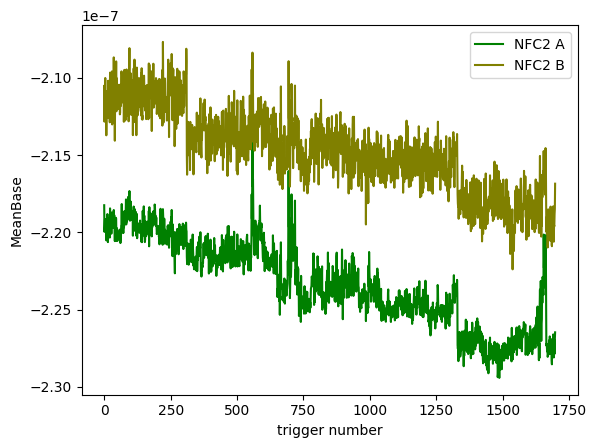

In [19]:
# look at baselines
for ch in chs:
    rq.plot1d(f'MeanBase_{ch}')
    # alternatively: plt.plot(RQs[f'MeanBase_{ch}'])

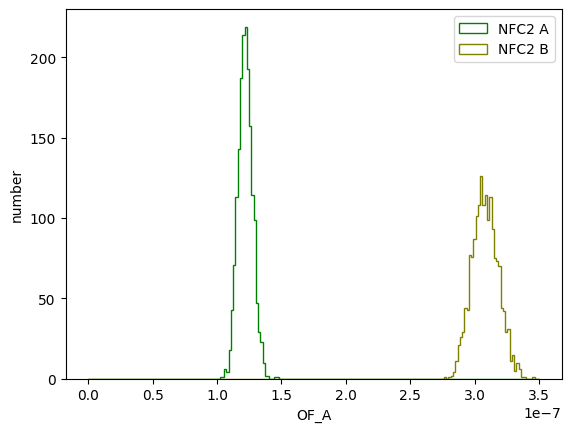

In [21]:
# "spectrum" plot
bins = np.linspace(0,3.5e-7,200)
for ch in chs:
    rq.hist1d(f'OF_A_{ch}',bins=bins)

158


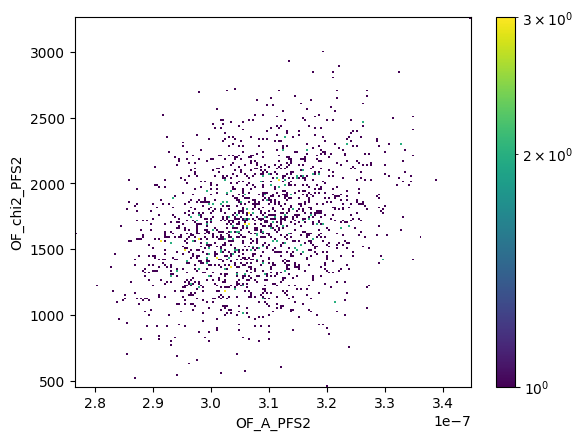

In [24]:
# chi2 vs amplitude plot
ch = chs[1]
rq.hist2d(f'OF_A_{ch}',f'OF_chi2_{ch}')

nchi2 = 2*(np.sum(psdfreq<maxchi2freq) - 1)
plt.axhline(nchi2,color='k',alpha=0.3)
print(nchi2)

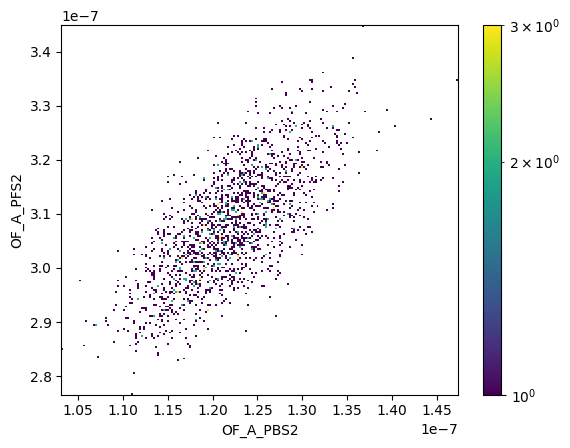

In [18]:
# "partition" plot
ch0,ch1 = chs
rq.hist2d(f'OF_A_{ch0}',f'OF_A_{ch1}')